# Artificial Intelligence Course - Fall 1402
## Computer Assignment #2 - Reinforcement Learning

<html>
<div>
  <span style="font-family: Poppins; font-size:30px; color: black;"> <br/> University of Tehran <br/>
</div>
<span style="font-family: Poppins; font-size:15pt; color: black; vertical-align: middle;"> Mobina Mehrazar </span><br>
<span style="font-family: Poppins; font-size:15pt; color: black; vertical-align: middle;"> 810100216 </span>

</html>

# Table of Contents

- [Part 1: Value Iteration & Policy Iteration Algorithms](#1)
    - [َQuestion 1:](#1-0)
    - [َQuestion 2:](#1-1)
    - [َQuestion 3:](#1-12)
    - [َQuestion 4:](#1-2)
    - [َQuestion 5:](#1-3)
        - [Value Iteration](#1-3-1)
        - [Policy Iteration](#1-3-2)
    - [َQuestion 6:](#1-4)
        - [Value Iteration](#1-4-1)
        - [Policy Iteration](#1-4-2)
- [Part 2: Q-Learning Algorithm](#2)
    - [َQuestion 8:](#2-1)
    - [َQuestion 9:](#2-2)
    - [َQuestion 10:](#2-3)

In [40]:
# import
import numpy as np
import gym
import matplotlib.pyplot as plt
import random
from tabulate import tabulate
import matplotlib.colors as mcolors
import time

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning, module="numpy", lineno=233)


In [41]:
def get_direction(dir):
    return {
        0: '←',
        1: '↓',
        2: '→',
        3: '↑'
    }.get(dir)

In [42]:
def clear_file(output_file):
    with open(output_file, 'w', encoding='utf-8') as file:
        print("", file=file)

### Some reinforcement learning components



<a name='1'></a>
## Part 1: Value Iteration & Policy Iteration Algorithms

<a name='1-0'></a>
### Question 1:

### Value Iteration algorithm and how it determines the optimal policy?

Value Iteration is a dynamic programming algorithm used to find the optimal policy for a Markov Decision Process (MDP). It's a simplified version compared to Policy Iteration.

A brief overview:

Initialization:
    Start with an arbitrary value function.

Value Update:

Update the value function iteratively for each state by considering the maximum expected cumulative reward achievable from taking any action (here all 4 actions) in that state. This is done through the Bellman optimality equation.

## Bellman Optimality Equation

$$V^*(s) = \max_a \sum_{s'} T(s, a, s')[R(s, a, s') + \gamma V^*(s')]$$

- $V^*(s)$ is the value of state $s$ under the optimal policy.
- $\max_a$ is the maximum over all actions $a$.
- $\sum_{s'}$ is the sum over all next states $s'$.
- $R(s, a, s') + \gamma V^*(s')$ is the expected return, consisting of the immediate reward plus the discounted future value of the next state $s'$.
- $\gamma$ is the discount factor.

To compute the utility for each state, we iterate through all states, calculating their utility values based on the information accumulated thus far for all other states. Once this process is completed for every state, we repeat the iteration. The initial step involves setting the utility for all states at iteration 0 as $V_{0}(s) = 0$ as shown in code.

$$ V_{k+1}(s) =  \max_a \sum_{s'} \biggl[T(s,a,s') \Bigl( R(s,a,s')+\gamma V_k(s')\Bigr)\biggr]$$

<!-- $$ V_{k+1}(s) =  max_a\display_frozenlake_frozenlakestyle\sum_{s'} \biggl[T(s,a,s') \Bigl( R(s,a,s')+\gamma V_k(s')\Bigr)\biggr]$$ -->

#### Convergence Check:

Check if the change in the value function is below a predefined threshold. If not, repeat step the algorithm. Note that the policy often converges long before the value convergence and this is one problem of this algorithm.

Once the value function has converged, extract the optimal policy by selecting the action in each state that maximizes the expected cumulative reward.

$$ \pi^*(s) =  argmax_a\displaystyle\sum_{s'} \biggl[T(s,a,s') \Bigl( R(s,a,s')+\gamma V^*(s')\Bigr)\biggr]$$

But in this problem, we saved the optimal $q-values$ and we can extract and decode actions as shown in code.

In Value Iteration, the algorithm directly computes the optimal value function, and the policy is derived from this optimal value function. The key insight is that by iteratively updating the value function based on the Bellman optimality equation, the algorithm converges to the optimal values for each state, allowing for the extraction of the optimal policy.

<a name='1-1'></a>
### Question 2:

In [43]:
class ValueIteration():
    def __init__(self, env, discount_factor, output_file, theta=1e-8):
        self.env = env
        self.discount_factor = discount_factor
        self.theta = theta
        self.reset()
        self.state_values = np.ones((self.env.observation_space.n)) / self.env.action_space.n
        self.q_values = np.ones((self.env.observation_space.n, self.env.action_space.n)) / self.env.action_space.n
        self.state_values[self.env.observation_space.n - 1] = 0
        self.q_values[self.env.observation_space.n - 1] = np.zeros((self.env.action_space.n))
        self.steps = 0
        self.rewards = 0
        self.output_file = output_file

    def get_total_steps(self):
        return self.steps

    def value_estimation(self):
        self.delta = np.inf
        self.steps = 0
        while(self.delta > self.theta):
            self.delta = 0
            for state in range(self.env.observation_space.n):
                v = self.state_values[state]
                for action in range(self.env.action_space.n):
                    action_value = 0
                    for probability, next_state, reward, done in self.env.P[state][action]:
                        action_value += probability * (reward + self.discount_factor * self.state_values[next_state])
                        self.rewards += reward
                    self.q_values[state, action] = action_value
                self.state_values[state] = np.max(self.q_values[state,:])
                self.delta = np.max([self.delta, abs(v - self.state_values[state])])
            self.steps += 1
            self.plot_optimal_policy(f"step: {self.steps}")
        return self.rewards

    def take_action(self, action):
        next_state, reward, done, _, _ = self.env.step(action)
        return next_state, reward, done

    def get_optimal_policy(self, state):
        return np.argmax(self.q_values[state,:])

    def get_state_values(self):
        return self.state_values

    def get_q_values(self):
        return self.q_values

    def reset(self):
        initial_state = self.env.reset()
        return initial_state

    def map_optimal_policy(self):
        policy = []
        for state in range(self.env.observation_space.n):
            policy.append(self.get_optimal_policy(state))
        return policy

    def plot_optimal_policy(self, title):
        policy = self.map_optimal_policy().copy()
        policy_directions = list(map(get_direction, policy))
        policy_directions = np.array(policy_directions).reshape(4, 4)
        policy_table = tabulate(policy_directions, tablefmt='fancy_grid')

        if title == "Optimal Policy":
            print(title)
            print(policy_table)
            return
        
        with open(self.output_file, 'a', encoding='utf-8') as file:
            print(title, file=file)
            print(policy_table, file=file)
    

    def plot_state_value(self):
        state_values = np.array(self.state_values).reshape(4, 4)
        fig, ax = plt.subplots()
        cax = ax.matshow(state_values, cmap='cool')
        fig.colorbar(cax)
        for i in range(state_values.shape[0]):
            for j in range(state_values.shape[1]):
                ax.text(j, i, f'{state_values[i, j]:.2f}', va='center', ha='center')
        ax.set_xticks(np.arange(-.5, 4, 1), minor=True)
        ax.set_yticks(np.arange(-.5, 4, 1), minor=True)
        ax.grid(which='minor', color='w', linestyle='-', linewidth=2)
        ax.grid(which='major', color='w', linestyle='-', linewidth=0)
        plt.title('State Values')
        plt.show()


<a name='1-12'></a>
### Question 3:

### Policy Iteration algorithm and how it determines the optimal policy?

Policy Iteration is another dynamic programming algorithm used to determine the optimal policy for a Markov Decision Process (MDP).

#### Initialization:
We start with an initial arbitrary policy.

#### Policy Evaluation:

Evaluate the value function for the current policy. This involves calculating the expected cumulative reward for each state under the current policy.

$$ V^{\pi}(s) = \displaystyle\sum_{s'} \biggl[T(s,\pi(s),s') \Bigl( R(s,\pi(s),s')+\gamma V^{\pi}(s')\Bigr)\biggr]$$

$$ V_{k+1}^{\pi_i}(s) = \displaystyle\sum_{s'} \biggl[T(s,\pi_i(s),s') \Bigl( R(s,\pi_i(s),s')+\gamma V_{k}^{\pi_i}(s')\Bigr)\biggr]$$

#### Policy Improvement:

Update the policy by selecting the action in each state that maximizes the expected cumulative reward. This is based on the current value function.

$$ \pi_{i+1}(s) = argmax_a\displaystyle\sum_{s'} \biggl[T(s,a,s') \Bigl( R(s,a,s')+\gamma V^{\pi_i}(s')\Bigr)\biggr]$$

#### Convergence Check:
Check if the policy has converged to an optimal policy. If not, repeat the algorithm. As we know the policy convergence is important to end the algorithm.


Policy Iteration alternates between policy evaluation and policy improvement, gradually converging to the optimal policy for the given MDP. The algorithm converges because with each iteration, the value function and policy improve until they reach the optimal values.

<a name='1-2'></a>
### Question 4:

In [44]:
class PolicyIteration():
    def __init__(self, env, discount_factor, output_file, theta=1e-8):
        self.env = env
        self.discount_factor = discount_factor
        self.theta = theta
        self.reset()
        self.state_values = np.ones((self.env.observation_space.n)) / self.env.action_space.n
        self.q_values = np.ones((self.env.observation_space.n, self.env.action_space.n)) / self.env.action_space.n
        self.state_values[self.env.observation_space.n - 1] = 0
        self.q_values[self.env.observation_space.n - 1] = np.zeros((self.env.action_space.n))
        self.policy = np.random.randint(self.env.action_space.n, size=self.env.observation_space.n)
        self.policy_stable = False
        self.steps = 0
        self.output_file = output_file
        self.rewards = 0

    def policy_evaluation(self):
        self.delta = np.inf
        while(self.delta >= self.theta):
            self.delta = 0
            for state in range(self.env.observation_space.n):
                v = self.state_values[state]
                new_state_value = 0
                for probability, next_state, reward, done in self.env.P[state][self.policy[state]]:
                    new_state_value += probability * (reward + self.discount_factor * self.state_values[next_state])
                self.state_values[state] = new_state_value
                self.delta = np.max([self.delta, abs(v - self.state_values[state])])
            self.steps += 1
            self.plot_optimal_policy(f"plicy evaluation: step: {self.steps}")

    def get_total_steps(self):
        return self.steps

    def policy_improvement(self):
        self.policy_stable = True
        for state in range(self.env.observation_space.n):
            old_policy = self.policy[state]
            for action in range(self.env.action_space.n):
                action_value = 0
                for probability, next_state, reward, done in self.env.P[state][action]:
                    action_value += probability * (reward + self.discount_factor * self.state_values[next_state])
                    self.rewards += reward
                self.q_values[state, action] = action_value
            self.policy[state] = np.argmax(self.q_values[state,:])
            if old_policy != self.policy[state]:
                self.policy_stable = False
        self.plot_optimal_policy(f"plicy improvement: step: {self.steps}")

    def policy_estimation(self):
        self.steps = 0
        self.policy_stable = False
        while not self.policy_stable:
            self.policy_evaluation()
            self.policy_improvement()
            # self.steps += 1
            self.plot_optimal_policy(f"plicy estimation: step: {self.steps}")
        return self.rewards

    def take_action(self, action):
        next_state, reward, done, _, _ = self.env.step(action)
        return next_state, reward, done

    def get_optimal_policy(self, state):
        return self.policy[state]

    def get_state_values(self):
        return self.state_values

    def get_q_values(self):
        return self.q_values

    def reset(self):
        initial_state, info = self.env.reset()
        return initial_state

    def plot_q_values(self):
        fig, axs = plt.subplots(4, 4, figsize=(5, 5))
        for i in range(4):
            for j in range(4):
                ax = axs[i, j]

                tri1 = np.array([[1, 1], [0, 1], [0.5, 0.5], [0.5, 0.5]])
                ax.fill(tri1[:, 0], tri1[:, 1], color=plt.cm.viridis(self.q_values[4*i+j, 3]))
                ax.text(0.5, 0.75, f"{self.q_values[4*i+j, 3]:.2f}", ha='center', va='center', color='k', fontsize=10)

                tri2 = np.array([[1, 0], [1, 1], [0.5, 0.5], [0.5, 0.5]])
                ax.fill(tri2[:, 0], tri2[:, 1], color=plt.cm.viridis(self.q_values[4*i+j, 2]))
                ax.text(0.75, 0.5, f"{self.q_values[4*i+j, 2]:.2f}", ha='center', va='center', color='k', fontsize=10)

                tri3 = np.array([[0, 0], [1, 0], [0.5, 0.5], [0.5, 0.5]])
                ax.fill(tri3[:, 0], tri3[:, 1], color=plt.cm.viridis(self.q_values[4*i+j, 1]))
                ax.text(0.5, 0.25, f"{self.q_values[4*i+j, 1]:.2f}", ha='center', va='center', color='k', fontsize=10)

                tri0 = np.array([[0, 1], [0, 0], [0.5, 0.5], [0.5, 0.5]])
                ax.fill(tri0[:, 0], tri0[:, 1], color=plt.cm.viridis(self.q_values[4*i+j, 0]))
                ax.text(0.25, 0.5, f"{self.q_values[4*i+j, 0]:.2f}", ha='center', va='center', color='k', fontsize=10)

                ax.set_xlim(0, 1)
                ax.set_ylim(0, 1)
                ax.axis('off')
                ax.set_yticks([])

        plt.subplots_adjust(wspace=.01, hspace=.01)
        plt.show()

    def plot_state_value(self):
        q_values = np.amax(self.q_values, axis=1).reshape(4, 4)
    
        fig, ax = plt.subplots()
        cax = ax.matshow(q_values, cmap='cool')
        fig.colorbar(cax)
        for i in range(q_values.shape[0]):
            for j in range(q_values.shape[1]):
                ax.text(j, i, f'{q_values[i, j]:.2f}', va='center', ha='center')
        ax.set_xticks(np.arange(-.5, 4, 1), minor=True)
        ax.set_yticks(np.arange(-.5, 4, 1), minor=True)
        ax.grid(which='minor', color='w', linestyle='-', linewidth=2)
        ax.grid(which='major', color='w', linestyle='-', linewidth=0)
        plt.title('State Values')
        plt.show()

    def map_optimal_policy(self):
        policy = []
        for state in range(self.env.observation_space.n):
            policy.append(self.get_optimal_policy(state))
        return policy

    def plot_optimal_policy(self, title):
        policy = self.map_optimal_policy().copy()
        policy_directions = list(map(get_direction, policy))
        policy_directions = np.array(policy_directions).reshape(4, 4)
        policy_table = tabulate(policy_directions, tablefmt='fancy_grid')

        if title == "Optimal Policy":
            print(title)
            print(policy_table)
            return
        
        with open(self.output_file, 'a', encoding='utf-8') as file:
            print(title, file=file)
            print(policy_table, file=file)

<a name='1-3'></a>
### Question 5:

In [45]:
EPISODES = 100

#### in play_frozenlake you can modify EPISODES to EPISODES=40

#### the plot time plotes the time took to converge in each iteration

In [46]:
def play_frozenlake(optimal_policy, EPISODES=1):
    for n in range(EPISODES):
        env = gym.make('FrozenLake-v1', render_mode="human", desc=None, map_name="4x4", is_slippery=False)

        agent = ValueIteration(env, 0.9, "policy.txt")
        state = agent.reset()
        state = state[0]
        done = False
        total_reward = 0
        while not done:
            action = optimal_policy[state]
            next_state, reward, done = agent.take_action(action)
            env.render()
            total_reward += reward
            state = next_state

        print(total_reward)

        env.close()
    return total_reward

def plot_time(title, data):
    plt.plot(data)
    plt.title(title)
    plt.xlabel("Episodes")
    plt.ylabel("Time (second)")
    plt.grid(True)
    plt.show()

<a name='1-3-1'></a>
#### Value Iteration:

Frozen Lake with Value Iteration


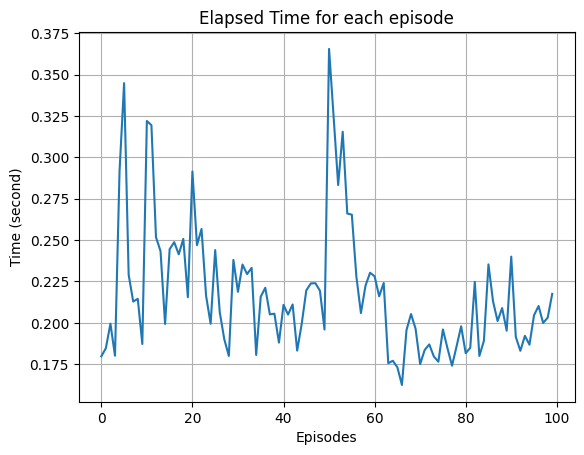

optimal policy for policy iteration:
Optimal Policy
╒═══╤═══╤═══╤═══╕
│ ↓ │ → │ ↓ │ ← │
├───┼───┼───┼───┤
│ ↓ │ ← │ ↓ │ ← │
├───┼───┼───┼───┤
│ → │ ↓ │ ↓ │ ← │
├───┼───┼───┼───┤
│ ← │ → │ → │ ← │
╘═══╧═══╧═══╧═══╛


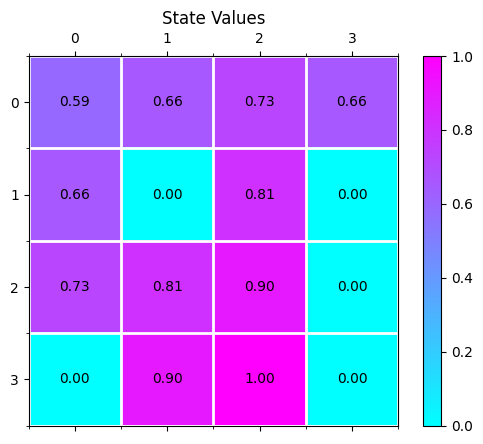

gained reward:


C:\Users\ASUS\AppData\Roaming\Python\Python311\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


1.0


In [47]:
print("Frozen Lake with Value Iteration")
env1 = gym.make('FrozenLake-v1', desc=None, map_name="4x4", is_slippery=False)
all_agents = []
all_rewards = [0] * EPISODES
avg_time = 0
converge_time_value_iteration = [0] * EPISODES
for episode in range(EPISODES):
    agent1 = ValueIteration(env1, 0.9, "value_iteration_policy.txt")
    start_time = time.time()
    if (episode+1 == EPISODES):
        clear_file("value_iteration_policy.txt")
    episode_reward = agent1.value_estimation()
    end_time = time.time()
    elapsed_time = end_time - start_time
    converge_time_value_iteration[episode] = elapsed_time
    avg_time += elapsed_time

    all_agents.append((episode_reward, agent1))

plot_time('Elapsed Time for each episode', converge_time_value_iteration)
avg_time = avg_time / EPISODES

agent = max(all_agents, key=lambda x: x[0])[1]
optimal_policy = []
optimal_policy = agent.map_optimal_policy()
print("optimal policy for policy iteration:")
agent.plot_optimal_policy("Optimal Policy")
agent.plot_state_value()
env1.close()
print("gained reward:")
gained_reward = play_frozenlake(optimal_policy)

#### I have stored additional data regarding the policy and the policy-changing process in a file.
note that all policies are saved in file named value_iteration_policy.txt

<a name='1-3-2'></a>
#### Policy Iteration:

Frozen Lake with Policy Iteration


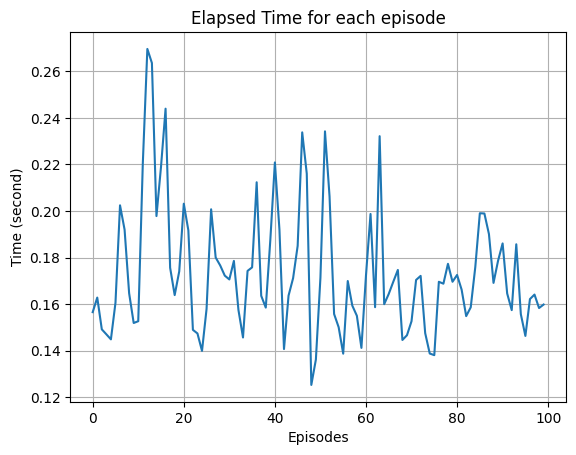

optimal policy for policy iteration:
Optimal Policy
╒═══╤═══╤═══╤═══╕
│ ↓ │ → │ ↓ │ ← │
├───┼───┼───┼───┤
│ ↓ │ ← │ ↓ │ ← │
├───┼───┼───┼───┤
│ → │ ↓ │ ↓ │ ← │
├───┼───┼───┼───┤
│ ← │ → │ → │ ← │
╘═══╧═══╧═══╧═══╛


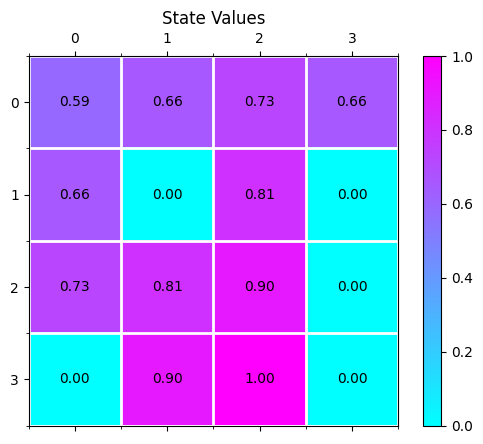

Q values:


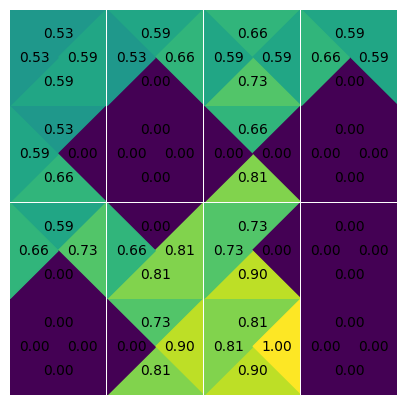

1.0


In [48]:
print("Frozen Lake with Policy Iteration")
env2 = gym.make('FrozenLake-v1', desc=None, map_name="4x4", is_slippery=False)
all_agents = []
all_rewards = [0] * EPISODES
avg_time = 0
converge_time_policy_iteration = [0] * EPISODES

for episode in range(EPISODES):
    agent2 = PolicyIteration(env2, 0.9, "policy_iteration_policy.txt")
    start_time = time.time()
    if (episode +1 == EPISODES):
        clear_file("policy_iteration_policy.txt")
    episode_reward = agent2.policy_estimation()
    end_time = time.time()
    elapsed_time = end_time - start_time
    converge_time_policy_iteration[episode] = elapsed_time
    avg_time += elapsed_time
    all_agents.append((episode_reward, agent2))

plot_time('Elapsed Time for each episode', converge_time_policy_iteration)
avg_time = avg_time / EPISODES
env2.close()

agent = max(all_agents, key=lambda x: x[0])[1]
optimal_policy = []
optimal_policy = agent.map_optimal_policy()
print("optimal policy for policy iteration:")
agent.plot_optimal_policy("Optimal Policy")
agent.plot_state_value()
print("Q values:")
agent.plot_q_values()
env2.close()
gained_reward = play_frozenlake(optimal_policy)

#### I have stored additional data regarding the policy and the policy-changing process in a file.
note that all policies are saved in file named policy_iteration_policy.txt


### Compare convergence time to Converge
#### Across all episodes from 0 to 100, it is evident that the time taken for the value iteration algorithm to converge exceeds that required by the policy iteration algorithm.

In Policy Iteration, the process of policy evaluation and policy improvement is performed sequentially and repeatedly until convergence, so, the sequential nature of Policy Iteration tends to reduce the variance in updates, making the learning process more stable.

noise is less in policy iteration.

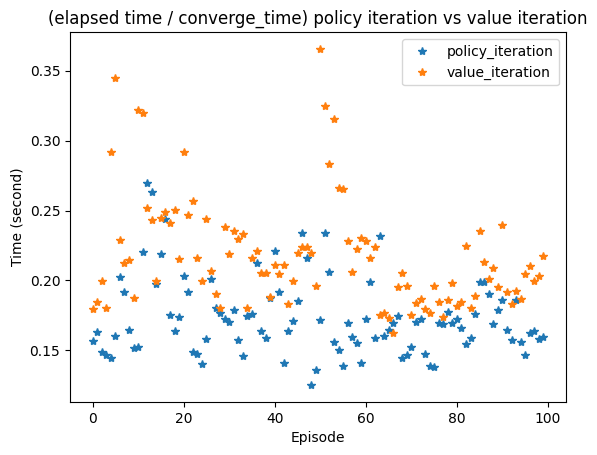

In [49]:
# plt.plot(converge_time_policy_iteration, label="policy_iteration")
# plt.plot(converge_time_value_iteration, label="value_iteration")
plt.plot(converge_time_policy_iteration, label="policy_iteration", marker='*', linestyle='')
plt.plot(converge_time_value_iteration, label="value_iteration", marker='*', linestyle='')
plt.xlabel("Episode")
plt.ylabel("Time (second)")
plt.title("(elapsed time / converge_time) policy iteration vs value iteration")
plt.legend()

<a name='1-4'></a>
### Question 6:

The convergence speed of policy iteration is often faster than that of value iteration. This is because policy iteration alternates between improving the policy and evaluating its value, leading to more targeted updates. In contrast, value iteration involves sweeping through all states and updating their values simultaneously.

After the convergence, both gave a policy which leads to wining the game with total 1 reward.

This difference can be seen in files i've created.


In the end, the optimal policy remains consistent across both methods, as the values generated converge to the same results. This convergence is attributed to the shared foundation of dynamic programming underpinning both algorithms.

<a name='2'></a>
## Part 2: Q-Learning Algorithm

<a name='2-1'></a>
### Question 7:
Q-learning is a model-free reinforcement learning algorithm that is used to find the optimal policy for an agent interacting with an environment.

this is the formulla that updates q table:

$$Q(s, a) \leftarrow (1 - \alpha) \cdot Q(s, a) + \alpha \cdot \left(r + \gamma \cdot \max_{a'} Q(s', a')\right)$$

Q(s,a) represents the Q-value for state s and action a.

α is the learning rate.

r is the immediate reward after taking action a in state s.

γ is the discount factor.

s′ is the next state.

a′ is the next action.


This update process allows the agent to iteratively refine its Q-table, progressively learning an optimal policy by considering both immediate rewards and the expected future rewards associated with different actions in various states.

<a name='2-1'></a>
### Question 8:

In [50]:
class QLearningAgent():
    def __init__(self, env, epsilon, learning_rate, discount_factor, seed):
        self.INITIAL_EPS = epsilon
        self.INITIAL_LR = learning_rate
        self.env = env
        self.epsilon = epsilon
        self.learning_rate = learning_rate
        self.olr = learning_rate
        self.discount_factor = discount_factor
        self.q_table = np.zeros((env.observation_space.n, env.action_space.n))
        self.seed = seed
        self.steps = 0

    def get_total_steps(self):
        return self.steps

    def get_random_action(self):
        return random.randint(0, self.env.action_space.n - 1)

    def get_optimal_action(self, state):
        return np.argmax(self.q_table[state])

    def choose_action(self, state):
        if np.random.uniform(0, 1) < self.epsilon:
            action = self.get_random_action()
        else:
            action = self.get_optimal_action(state)
        return action

    def take_action(self, action):
        next_state, reward, done, _, _ = self.env.step(action)
        return next_state, reward, done
    
    def get_optimal_policy(self, state):
        return np.argmax(self.q_table[state])

    def get_q_values(self):
        return self.q_table

    def reset(self):
        initial_state, _ = self.env.reset(seed=self.seed)
        return initial_state

    def update_q_table(self, state, action, nextState, reward):
        old_value = self.q_table[state, action]
        next_max = np.max(self.q_table[nextState])
        new_value = (1 - self.learning_rate) * old_value + self.learning_rate * (reward + self.discount_factor * next_max)
        self.q_table[state, action] = new_value
        self.steps += 1

    def get_epsilon(self):
        return self.epsilon

    def change_epsilon_to(self, amount):
        self.epsilon = amount

    def change_env(self, env):
        self.env = env

    def dec_learning_rate(self, episode):
        self.learning_rate = self.INITIAL_LR * (0.95 ** (episode / 50))
        return self.learning_rate


    def dec_epsilon(self, episode, total_episodes):
        self.epsilon = self.INITIAL_EPS * (1 - (episode / total_episodes))
        return self.epsilon

    def dec_epsilon_2(self, episode, total_episodes):
        self.epsilon = self.INITIAL_EPS * (0.95 ** (episode / 50))
        return self.epsilon

decrease policy of dec_epsilon

After the initial 100 iterations, epsilon decreases by half of its original amount.

$epsilon = \text{INITIALEPSILON} \times \left(1 - \frac{\text{episode}}{\text{total\_episode}}\right)$

decrease policy of dec_epsilon_2

$epsilon = \text{INITIALEPSILON} \times 0.95^{\lfloor (1 + \text{episode})/50 \rfloor}$

 In my exploration, I found that step decay resulted in the swiftest convergence speed.
### note that you can uncomment the policy you want to use


decrease policy of dec_learning_rate

$learning_rate = \text{INITIALLEARNINGRATE} \times 0.95^{\lfloor (1 + \text{episode})/50 \rfloor}$


In [51]:
# hyperparameters
REPS = 20
EPISODES = 2000
EPSILON = 0.1
LEARNING_RATE = 0.1
DISCOUNT = 0.9
STUDENT_NUM = 216

<a name='2-2'></a>
### Question 9:

#### you can set episodes to 40 in play_taxi
#### the plot_rewards_per_episode function plots mean rewards per episode note that each episode is run REPS time

In [52]:
  
def plot_per_episode(data, title, ylabel):
    plt.figure(figsize=(10, 5))
    plt.plot(data)
    plt.title(title)
    plt.xlabel('Trainig Episode')
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.show()

def play_taxi(agent, episodes=1):
    agent.change_epsilon_to(0)
    env = gym.make('Taxi-v3', render_mode="human")
    agent.change_env(env)
    reward_sum = 0
    for episode in range(episodes):
        total_reward = 0
        state = agent.reset()
        done = False
        while not done:
            bestAction = agent.get_optimal_action(state) #optimal action
            next_state, reward, done = agent.take_action(bestAction)
            agent.update_q_table(state, bestAction, next_state, reward)
            env.render()
            total_reward += reward
            state = next_state
        reward_sum += total_reward
    mean_reward = reward_sum / episodes
    env.close()
    return mean_reward

### Fix learning rate

In [53]:
env3 = gym.make('Taxi-v3')
all_agents = []
all_eps = [-100] * EPISODES 
all_rewards_fixed_lr = [0] * EPISODES
all_times_fixed_lr = [0] * EPISODES

for rep in range(REPS):
    agent3 = QLearningAgent(env3, EPSILON, LEARNING_RATE, DISCOUNT, STUDENT_NUM)

    for episode in range(EPISODES):
        # eps = agent3.dec_epsilon(episode, EPISODES)
        eps = agent3.dec_epsilon_2(episode, EPISODES)
        all_eps[episode] = eps
        start_time = time.time()
        state = agent3.reset()
        episode_reward = 0

        while True:
            bestAction = agent3.choose_action(state)
            next_state, reward, done = agent3.take_action(bestAction)
            agent3.update_q_table(state, bestAction, next_state, reward)  
            state = next_state
            episode_reward += reward

            if done:
                break
        end_time = time.time()
        elapsed_time = end_time - start_time
        all_times_fixed_lr[episode] += elapsed_time
        all_rewards_fixed_lr[episode] += episode_reward

    agent3.reset()

    all_agents.append((episode_reward, agent3))
env3.close()


mean of rewards are calculated for all REPS and ploted for fixed learning rate:


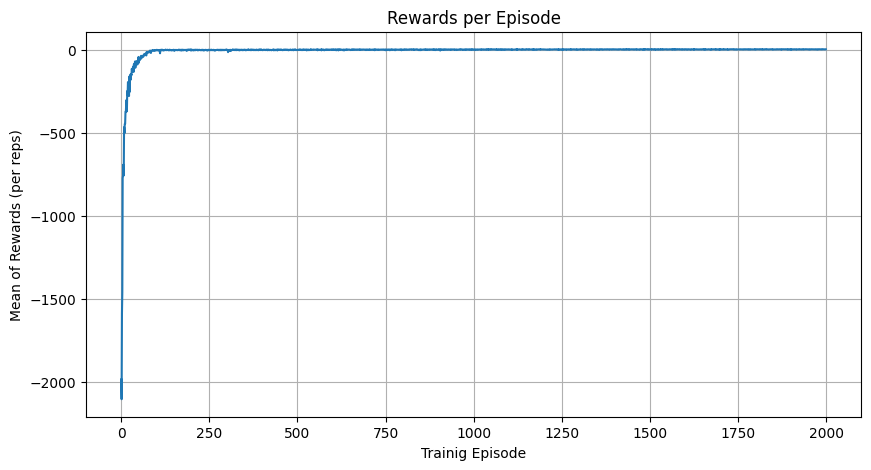

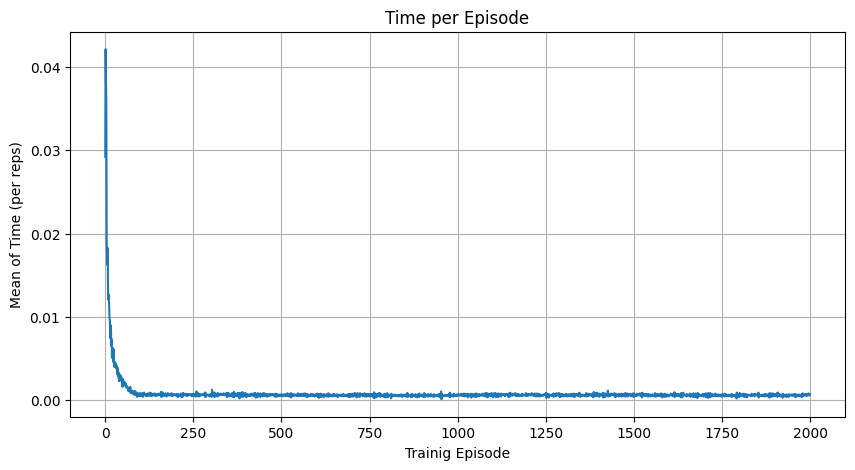

reward in episode 250 = 0.85 whici is very close to best reward
2000


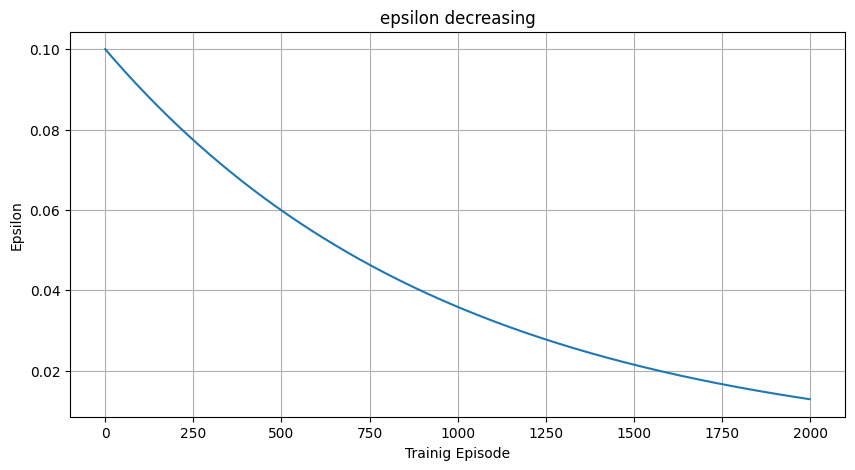

In [54]:
all_rewards_fixed_lr = [reward / REPS for reward in all_rewards_fixed_lr]
all_times_fixed_lr = [t / REPS for t in all_times_fixed_lr]

print("mean of rewards are calculated for all REPS and ploted for fixed learning rate:")

plot_per_episode(all_rewards_fixed_lr, 'Rewards per Episode', 'Mean of Rewards (per reps)')
plot_per_episode(all_times_fixed_lr, 'Time per Episode', 'Mean of Time (per reps)')

print(f"reward in episode 250 = {all_rewards_fixed_lr[250]} whici is very close to best reward")

print(len(all_eps))
plot_per_episode(all_eps, 'epsilon decreasing', 'Epsilon')

In [55]:
agent = max(all_agents, key=lambda x: x[0])[1]
gained_reward = play_taxi(agent)
print(f"mean of all gained rewards per 40 episodes of best acting agent in environment: {gained_reward}")

mean of all gained rewards per 40 episodes of best acting agent in environment: 7.0


Upon analysis, it becomes evident that, following 250 training episodes, the reward value converges closely to zero. This trend signifies a notable increase, indicative of the reinforcement of a well-learned policy.

### Decreasing learning rate

In [56]:
env3 = gym.make('Taxi-v3')
all_agents = []
all_eps = [-100] * EPISODES 
all_lr = [-100] * EPISODES 
all_rewards_decreasing_lr = [0] * EPISODES
all_times_decreasing_lr = [0] * EPISODES

for rep in range(REPS):
    agent3 = QLearningAgent(env3, EPSILON, LEARNING_RATE, DISCOUNT, STUDENT_NUM)

    for episode in range(EPISODES):
        eps = agent3.dec_epsilon_2(episode, EPISODES)
        lr = agent3.dec_learning_rate(episode)
        all_eps[episode] = eps
        all_lr[episode] = lr
        start_time = time.time()
        state = agent3.reset()
        episode_reward = 0

        while True:
            bestAction = agent3.choose_action(state)
            next_state, reward, done = agent3.take_action(bestAction)
            agent3.update_q_table(state, bestAction, next_state, reward)  
            state = next_state
            episode_reward += reward

            if done:
                break
        end_time = time.time()
        elapsed_time = end_time - start_time
        all_times_decreasing_lr[episode] += elapsed_time
        all_rewards_decreasing_lr[episode] += episode_reward

    agent3.reset()

    all_agents.append((episode_reward, agent3))
env3.close()


mean of rewards are calculated for all REPS and ploted for decreasing learning rate:


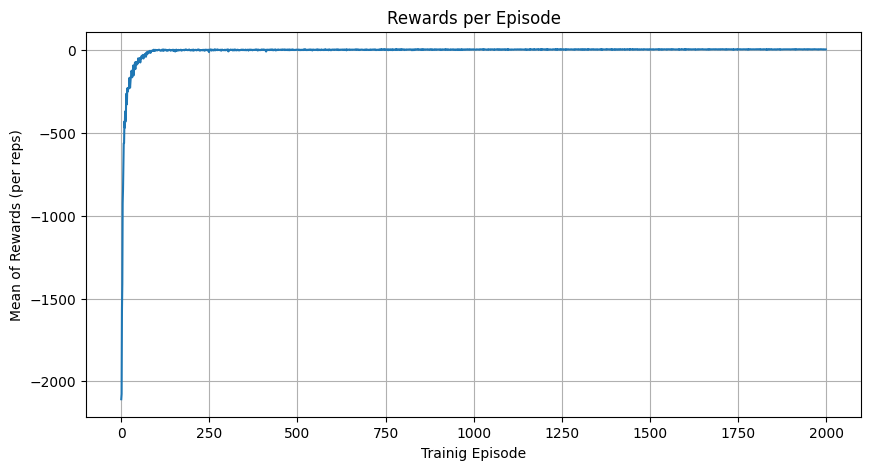

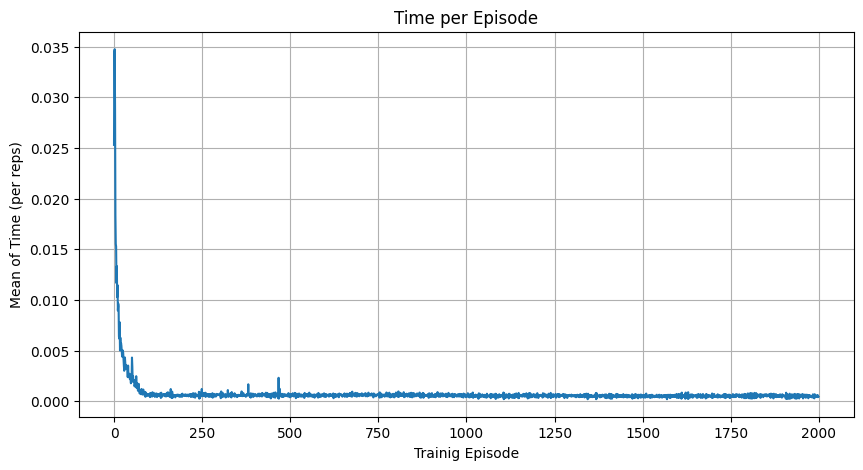

mean of all gained rewards per 40 episodes of best acting agent in environment: 7.0
2000


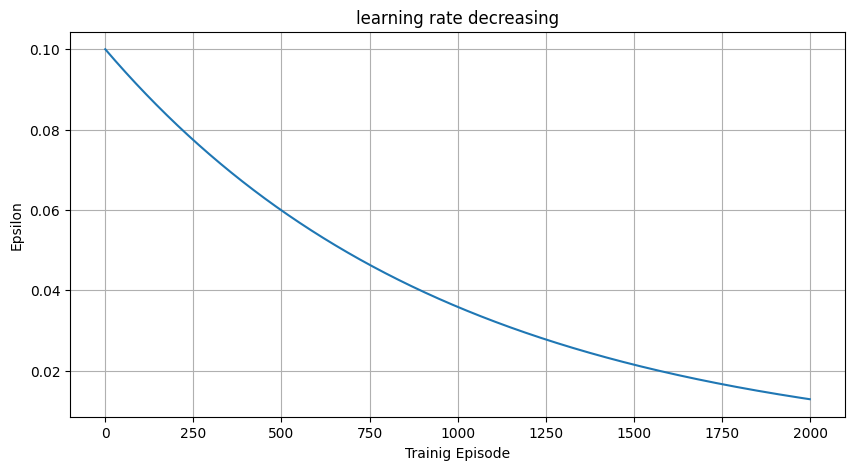

In [57]:
all_times_decreasing_lr = [t / REPS for t in all_times_decreasing_lr]
all_rewards_decreasing_lr = [reward / REPS for reward in all_rewards_decreasing_lr]
print("mean of rewards are calculated for all REPS and ploted for decreasing learning rate:")
plot_per_episode(all_rewards_decreasing_lr, 'Rewards per Episode', 'Mean of Rewards (per reps)')
plot_per_episode(all_times_decreasing_lr, 'Time per Episode', 'Mean of Time (per reps)')

agent = max(all_agents, key=lambda x: x[0])[1]
gained_reward = play_taxi(agent)
print(f"mean of all gained rewards per 40 episodes of best acting agent in environment: {gained_reward}")

print(len(all_lr))
plot_per_episode(all_lr, 'learning rate decreasing', 'Epsilon')


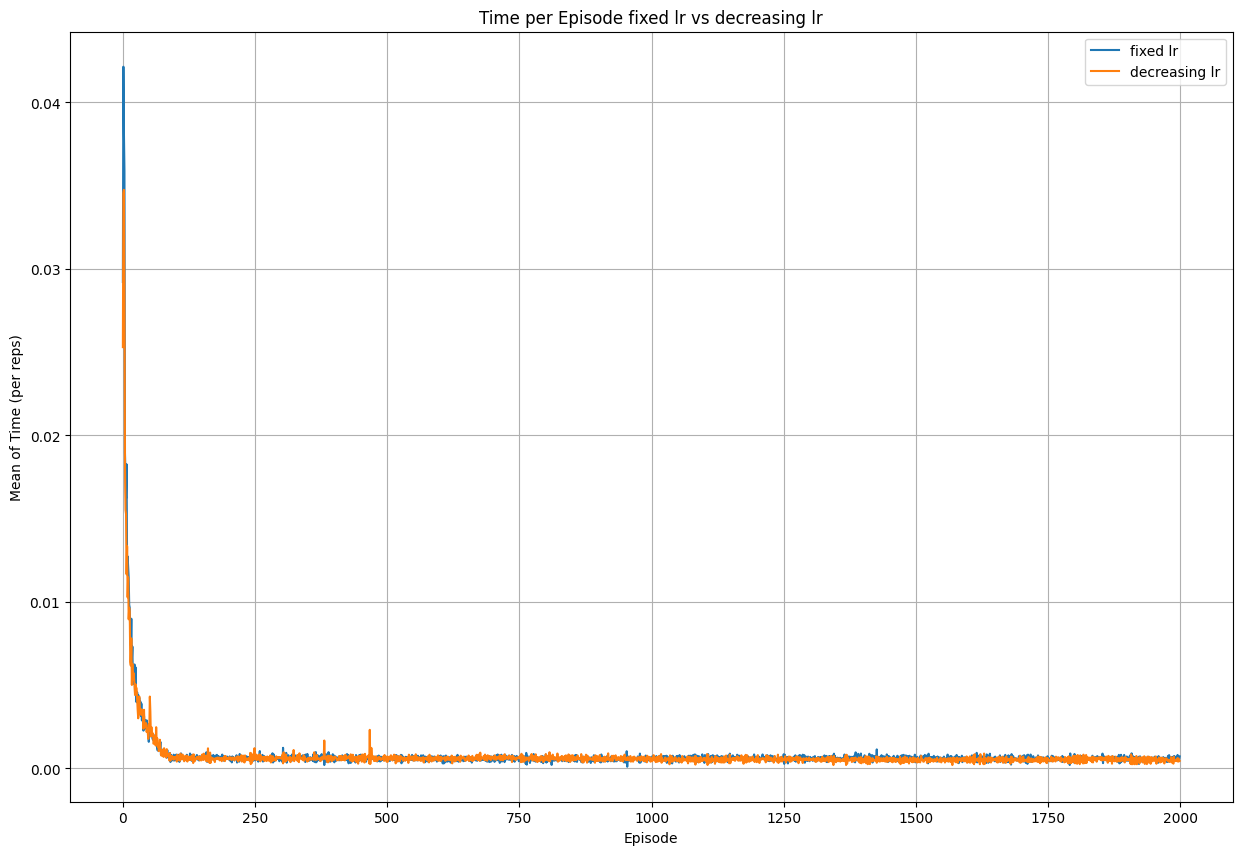

In [58]:
# plt.figure(figsize=(10, 5))
plt.figure(figsize=(15, 10))  # Set the figure size to (12, 6)
plt.plot(all_times_fixed_lr, label="fixed lr")
plt.plot(all_times_decreasing_lr, label="decreasing lr")
plt.title('Time per Episode fixed lr vs decreasing lr')
plt.xlabel('Episode')
plt.ylabel('Mean of Time (per reps)')
plt.grid(True)
plt.legend()
plt.show()

as we can see converngence of algorithm in decreasing learning rate is a little bit faster but in overal they act same

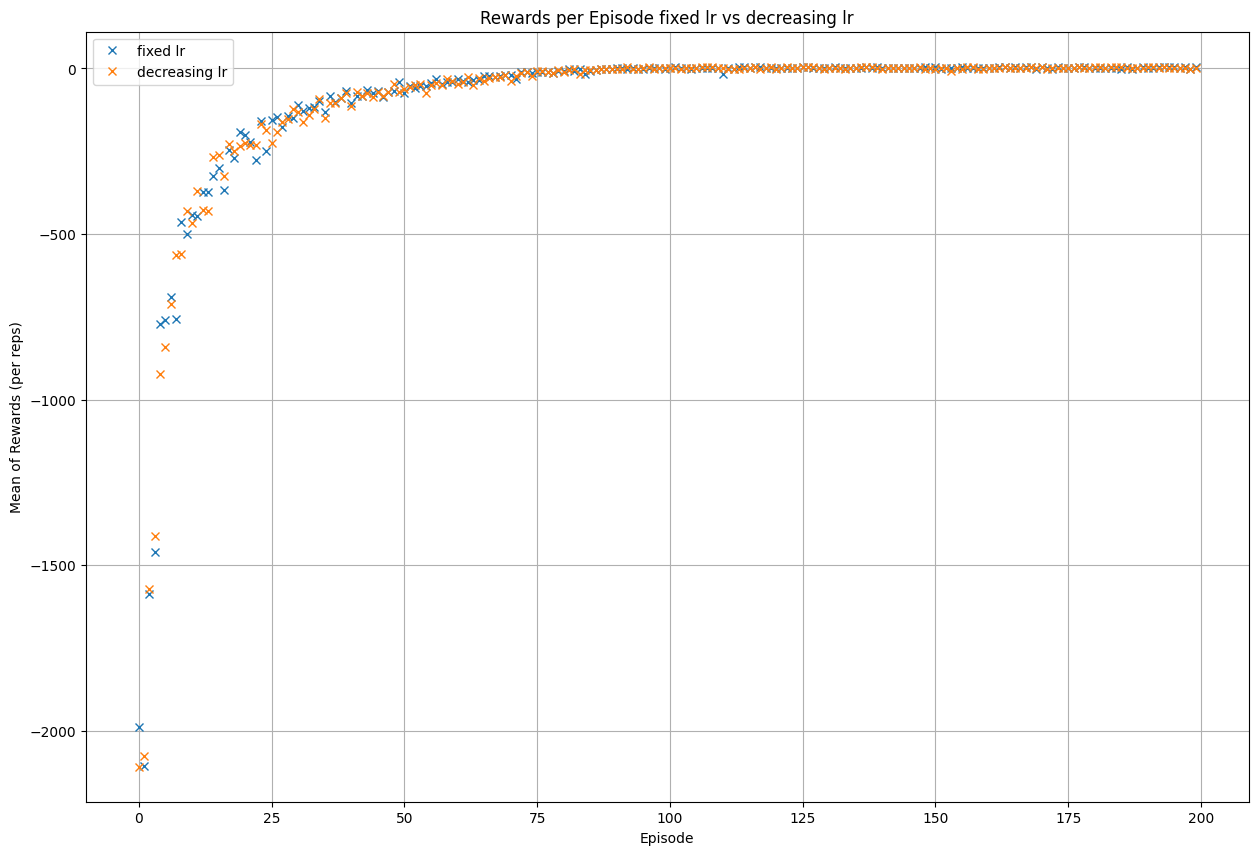

In [59]:
plt.figure(figsize=(15, 10))
# plt.plot(all_rewards_fixed_lr, label="fixed lr")
# plt.plot(all_rewards_decreasing_lr, label="decreasing lr")
plt.plot(all_rewards_fixed_lr[:200], label="fixed lr", marker='x', linestyle='')
plt.plot(all_rewards_decreasing_lr[:200], label="decreasing lr", marker='x', linestyle='')
# plt.plot(all_rewards_fixed_lr[:200], label="fixed lr")
# plt.plot(all_rewards_decreasing_lr[:200], label="decreasing lr")
plt.title('Rewards per Episode fixed lr vs decreasing lr')
plt.xlabel('Episode')
plt.ylabel('Mean of Rewards (per reps)')
plt.grid(True)
plt.legend()
plt.show()

The method of decreasing learning rate typically leads to faster convergence and because of a faster convergence, the noise is less that fixed learning rate.
Typically decreasing learning rate gets bigger rewards in same episode. (living in env has -1 reward!) but in this problem it is not that obvious.
 
Primarily due to the fact that, with smaller epsilon values, the algorithm tends to decide the next action based on its established policy and for a better convergence we use it.
I've tried the fixed epsilon and conclueded this.

Utilizing a decreasing learning rate policy facilitates swifter convergence, especially in challenging problems where achieving convergence is inherently difficult.

<a name='2-3'></a>
### Question 10:

This is shown in Question 9.